In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.family'] = 'serif'

In [2]:
df = pd.read_csv("datascience_finaldataset.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Week                  40 non-null     int64  
 1   Date                  40 non-null     object 
 2   Split                 40 non-null     object 
 3   Focus_Lift            40 non-null     object 
 4   Set_Details_lbs       30 non-null     object 
 5   Max_Rep_Weight_lbs    30 non-null     float64
 6   Total_Volume_lbs      30 non-null     float64
 7   Saturday_Sleep_Hours  10 non-null     float64
 8   Run_Time              10 non-null     object 
 9   Pace_min_km           10 non-null     object 
dtypes: float64(3), int64(1), object(6)
memory usage: 3.3+ KB


In [3]:
df.head()

,Week,Date,Split,Focus_Lift,Set_Details_lbs,Max_Rep_Weight_lbs,Total_Volume_lbs,Saturday_Sleep_Hours,Run_Time,Pace_min_km
0,1,01/12/2025,Upper A,Incline Bench Machine,"88x10, 88x8, 88x9",88.0,2376.0,NaN,NaN,NaN
1,1,01/12/2025,Upper A,Assisted Pull-Up Machince,"44.8x10, 44.8x10, 44.8x10",44.8,1344.0,NaN,NaN,NaN
2,1,02/12/2025,Lower A,Leg Press,"110x10, 110x10, 110x10",110.0,3300.0,NaN,NaN,NaN
3,1,07/12/2025,Running,5k,NaN,NaN,NaN,4.0,38:45:00,07:45
4,2,08/12/2025,Upper A,Incline Bench Machine,"99x10, 99x8, 88x9",99.0,2574.0,NaN,NaN,NaN


In [4]:
df.isna().sum()

Week                     0
Date                     0
Split                    0
Focus_Lift               0
Set_Details_lbs         10
Max_Rep_Weight_lbs      10
Total_Volume_lbs        10
Saturday_Sleep_Hours    30
Run_Time                30
Pace_min_km             30
dtype: int64

## PRE-PROCESSING

In [5]:

LBS_TO_KG = 2.20462
def convert_pace(p):
    if pd.isna(p): return None
    pts = str(p).split(':')
    return int(pts[0]) * 60 + int(pts[1]) if len(pts) == 2 else None

df['Total_Volume_kg'] = df['Total_Volume_lbs'] / LBS_TO_KG
df['Max_Rep_Weight_kg'] = df['Max_Rep_Weight_lbs'] / LBS_TO_KG
df['Pace_sec'] = df['Pace_min_km'].apply(convert_pace)

df_final = df[df['Week'] <= 10].drop(columns=[
    'Date', 'Set_Details_lbs', 'Run_Time', 'Pace_min_km', 
    'Total_Volume_lbs', 'Max_Rep_Weight_lbs'
]).copy()

run_df = df_final[df_final['Split'] == 'Running'].dropna(subset=['Pace_sec'])
leg_df = df_final[df_final['Focus_Lift'] == 'Leg Press']

print("--- DATA CLEANING COMPLETE ---")
print(f"Remaining Features: {df_final.columns.tolist()}")
df_final.head()

--- DATA CLEANING COMPLETE ---
Remaining Features: ['Week', 'Split', 'Focus_Lift', 'Saturday_Sleep_Hours', 'Total_Volume_kg', 'Max_Rep_Weight_kg', 'Pace_sec']


,Week,Split,Focus_Lift,Saturday_Sleep_Hours,Total_Volume_kg,Max_Rep_Weight_kg,Pace_sec
0,1,Upper A,Incline Bench Machine,NaN,1077.736753,39.916176,NaN
1,1,Upper A,Assisted Pull-Up Machince,NaN,609.628870,20.320962,NaN
2,1,Lower A,Leg Press,NaN,1496.856601,49.895220,NaN
3,1,Running,5k,4.0,NaN,NaN,465.0
4,2,Upper A,Incline Bench Machine,NaN,1167.548149,44.905698,NaN


## DESCRIPTIVE STATISTICS

In [6]:
stats_summary = df.groupby(['Split', 'Focus_Lift']).agg({
    'Total_Volume_kg': ['mean', 'std'],
    'Max_Rep_Weight_kg': ['mean', 'max'],
    'Pace_sec': ['mean', 'std'],
    'Saturday_Sleep_Hours': 'mean'
}).round(2)
display(stats_summary)

Total_Volume_kg         Max_Rep_Weight_kg  \
                                             mean     std              mean   
Split   Focus_Lift                                                            
Lower A Leg Press                         2661.86  513.89             90.67   
Running 5k                                    NaN     NaN               NaN   
Upper A Assisted Pull-Up Machince          333.72  126.72             12.82   
        Incline Bench Machine             1117.65  106.44             45.40   

                                          Pace_sec        Saturday_Sleep_Hours  
                                      max     mean    std                 mean  
Split   Focus_Lift                                                              
Lower A Leg Press                  110.00      NaN    NaN                  NaN  
Running 5k                            NaN    442.1  44.57                  6.1  
Upper A Assisted Pull-Up Machince   20.32      NaN    NaN                  NaN  
        Incline Bench Machine       49.90      NaN    NaN                  NaN

In [7]:
def validate_model(data, x_col, y_col):
    clean = data.dropna(subset=[x_col, y_col])
    X = clean[[x_col]]
    y = clean[y_col]
    
    model = LinearRegression().fit(X, y)
    pearson_r, p_val = stats.pearsonr(clean[x_col], y)
    
    return {
        'Slope': model.coef_[0],
        'Pearson_r': pearson_r,
        'p_value': p_val,
        'R2': model.score(X, y)
    }

In [8]:
results = []

# Analyze Leg Press
lp_res = validate_model(leg_df, 'Week', 'Total_Volume_kg')
results.append({'Variable': 'Leg Press Vol', **lp_res})

# Analyze Running Pace
run_res = validate_model(run_df, 'Week', 'Pace_sec')
results.append({'Variable': '5k Run Pace', **run_res})

val_df = pd.DataFrame(results).round(4)
val_df['Significant'] = val_df['p_value'] < 0.05
display(val_df)

,Variable,Slope,Pearson_r,p_value,R2,Significant
0,Leg Press Vol,146.4316,0.8627,0.0013,0.7443,True
1,5k Run Pace,-11.6667,-0.7925,0.0063,0.6281,True


In [9]:
# 1. Define the running data subset
running_data = df_final[df_final['Split'] == 'Running']

leg_vol_weekly = df_final[df_final['Focus_Lift'] == 'Leg Press'].groupby('Week')['Total_Volume_kg'].sum().reset_index()

interference_df = pd.merge(leg_vol_weekly, running_data[['Week', 'Pace_sec', 'Saturday_Sleep_Hours']], on='Week')

# 4. Correlation 1: Leg Volume vs Pace (Interference Effect)
clean_int = interference_df.dropna(subset=['Total_Volume_kg', 'Pace_sec'])
r_int, p_int = stats.pearsonr(clean_int['Total_Volume_kg'], clean_int['Pace_sec'])

# 5. Correlation 2: Sleep vs Pace (Recovery Impact)
clean_sleep = interference_df.dropna(subset=['Saturday_Sleep_Hours', 'Pace_sec'])
r_sleep, p_sleep = stats.pearsonr(clean_sleep['Saturday_Sleep_Hours'], clean_sleep['Pace_sec'])

print(f"--- INTERFERENCE & RECOVERY RESULTS ---")
print(f"Interference Correlation (Leg Vol vs. Pace): r = {r_int:.4f} (p = {p_int:.4f})")
print(f"Recovery Correlation (Sleep vs. Pace): r = {r_sleep:.4f} (p = {p_sleep:.4f})")

--- INTERFERENCE & RECOVERY RESULTS ---
Interference Correlation (Leg Vol vs. Pace): r = -0.5265 (p = 0.1180)
Recovery Correlation (Sleep vs. Pace): r = -0.5289 (p = 0.1160)


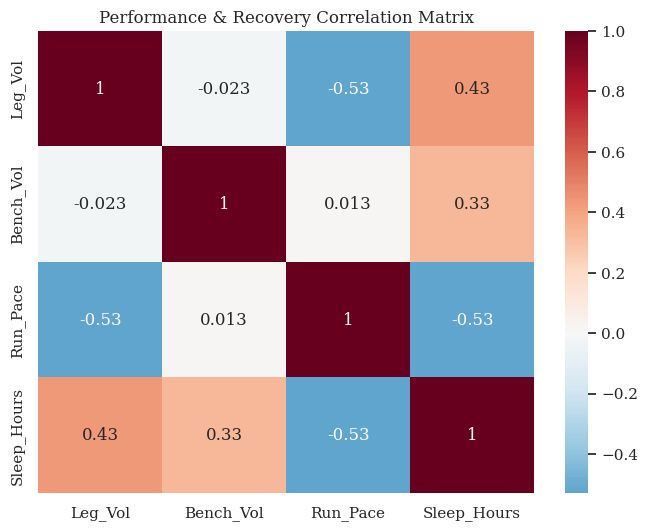

In [10]:
weekly_leg = leg_df.groupby('Week')['Total_Volume_kg'].sum()
weekly_bench = df_final[df_final['Focus_Lift'] == 'Incline Bench Machine'].groupby('Week')['Total_Volume_kg'].sum()
weekly_run = run_df.set_index('Week')[['Pace_sec', 'Saturday_Sleep_Hours']]

corr_table = pd.concat([weekly_leg, weekly_bench, weekly_run], axis=1)
corr_table.columns = ['Leg_Vol', 'Bench_Vol', 'Run_Pace', 'Sleep_Hours']

plt.figure(figsize=(8, 6))
sns.heatmap(corr_table.corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Performance & Recovery Correlation Matrix')
plt.savefig('correlation_heatmap.png')
plt.show()

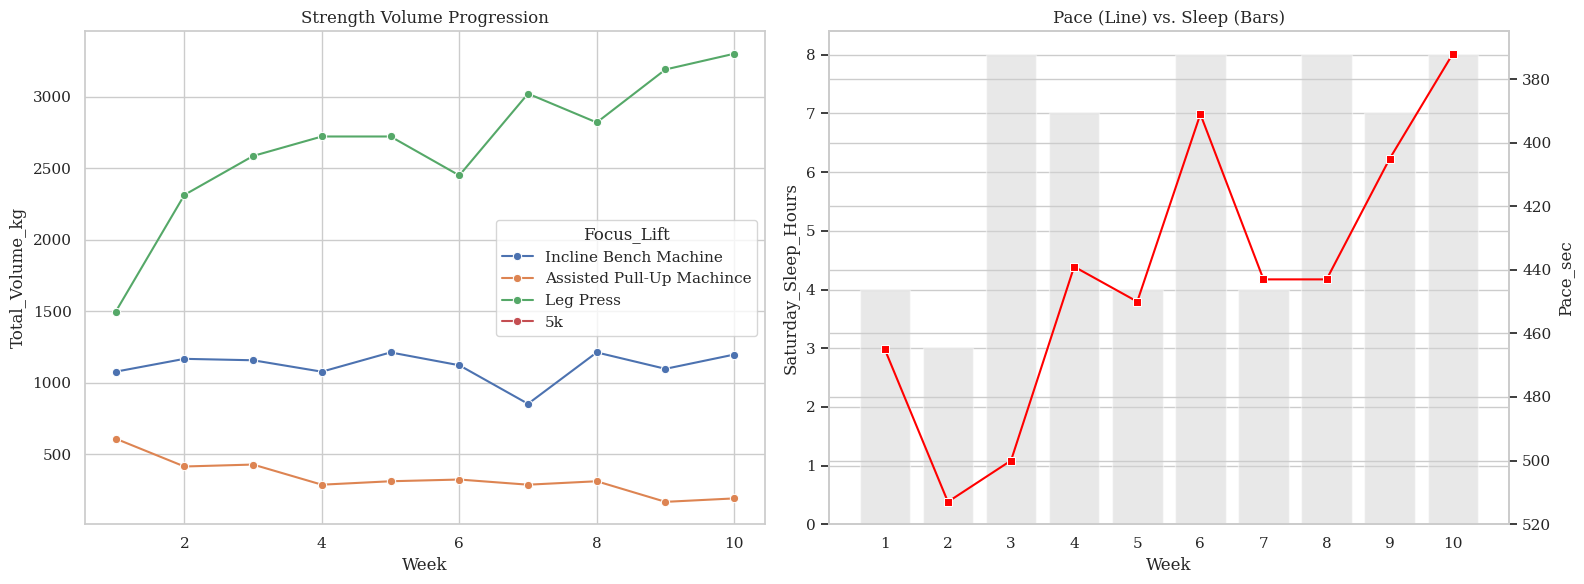

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data=df_final[df_final['Focus_Lift'].notna()], 
             x='Week', y='Total_Volume_kg', hue='Focus_Lift', marker='o', ax=ax1)
ax1.set_title('Strength Volume Progression')

ax2_twin = ax2.twinx()
sns.barplot(data=run_df, x='Week', y='Saturday_Sleep_Hours', color='lightgrey', alpha=0.5, ax=ax2)
sns.lineplot(data=run_df, x=run_df['Week']-1, y='Pace_sec', color='red', marker='s', ax=ax2_twin)
ax2.set_title('Pace (Line) vs. Sleep (Bars)')
ax2_twin.invert_yaxis() # Faster pace = lower seconds

plt.tight_layout()
plt.show()

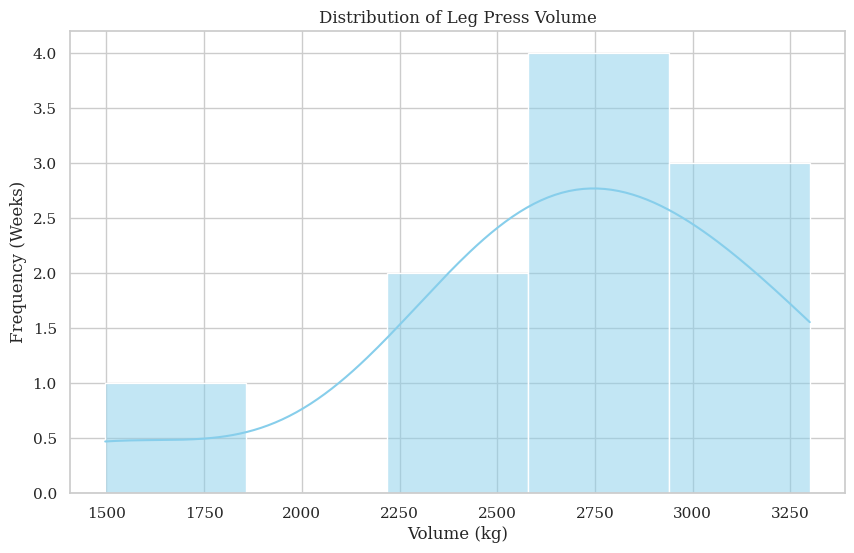

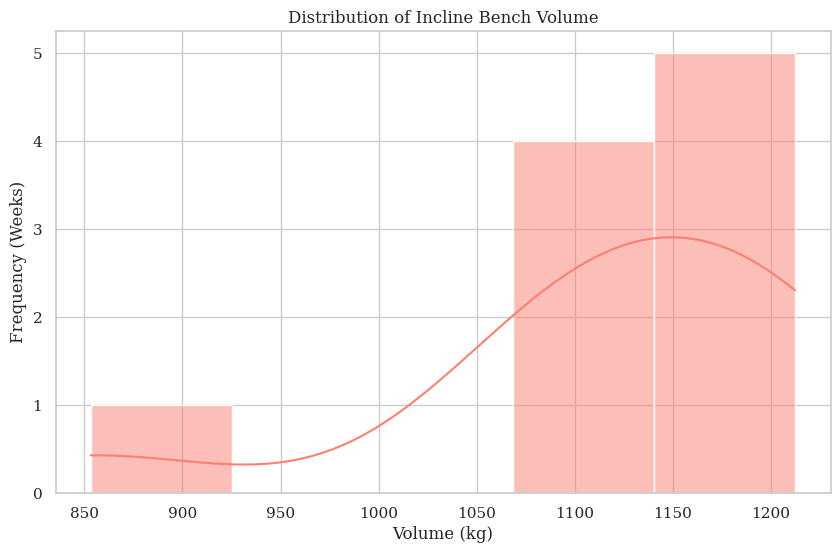

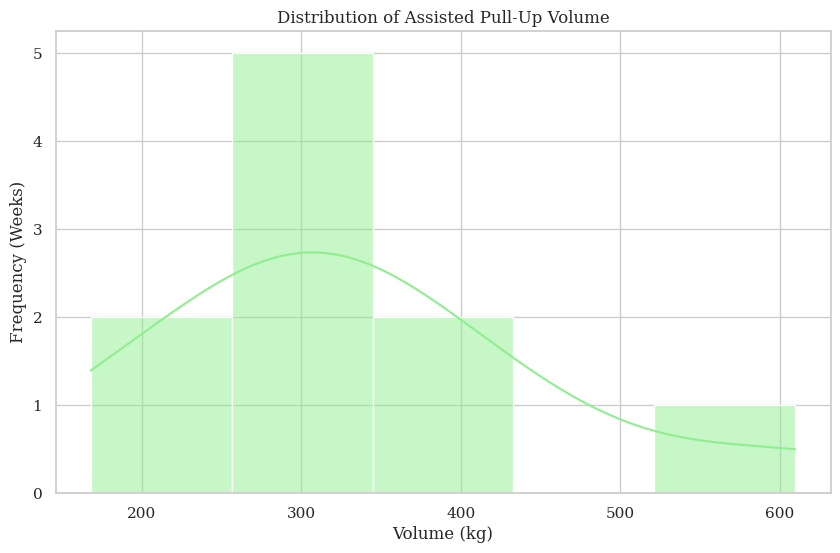

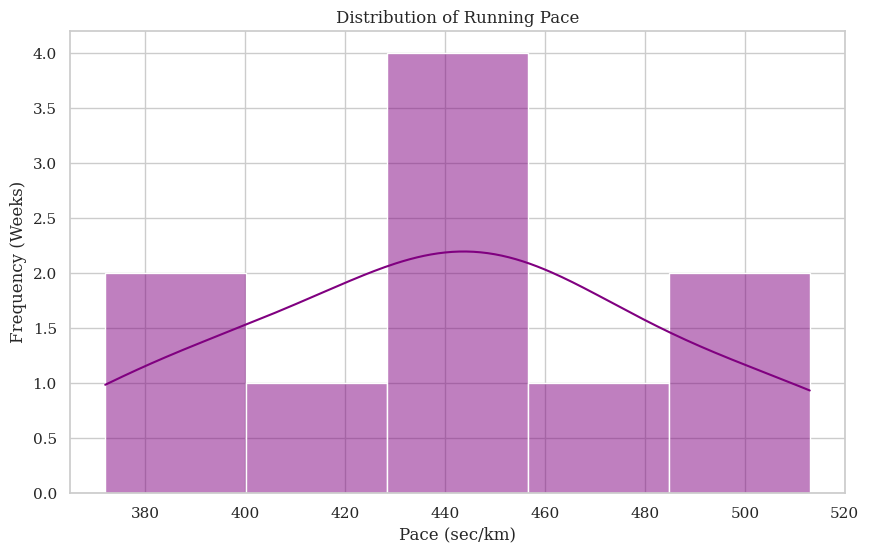

--- Statistical Results ---
P-Value: 0.1160
R-Squared (Effect Size): 0.2798


In [12]:
# --- 3. GENERATING SEPARATE HISTOGRAMS ---

# Histogram: Leg Press
plt.figure()
sns.histplot(df[df['Focus_Lift'] == 'Leg Press']['Total_Volume_kg'], kde=True, color='skyblue')
plt.title('Distribution of Leg Press Volume')
plt.xlabel('Volume (kg)')
plt.ylabel('Frequency (Weeks)')
plt.savefig('hist_leg_press.png')
plt.show()

# Histogram: Incline Bench
plt.figure()
sns.histplot(df[df['Focus_Lift'] == 'Incline Bench Machine']['Total_Volume_kg'], kde=True, color='salmon')
plt.title('Distribution of Incline Bench Volume')
plt.xlabel('Volume (kg)')
plt.ylabel('Frequency (Weeks)')
plt.savefig('hist_incline_bench.png')
plt.show()

# Histogram: Assisted Pull-Up
plt.figure()
sns.histplot(df[df['Focus_Lift'] == 'Assisted Pull-Up Machince']['Total_Volume_kg'], kde=True, color='lightgreen')
plt.title('Distribution of Assisted Pull-Up Volume')
plt.xlabel('Volume (kg)')
plt.ylabel('Frequency (Weeks)')
plt.savefig('hist_pull_up.png')
plt.show()

# Histogram: Running Pace
plt.figure()
run_data = df[df['Split'] == 'Running']['Pace_sec'].dropna()
sns.histplot(run_data, kde=True, color='purple')
plt.title('Distribution of Running Pace')
plt.xlabel('Pace (sec/km)')
plt.ylabel('Frequency (Weeks)')
plt.savefig('hist_run_pace.png')
plt.show()

# --- 6. STATISTICAL TEST (Regression) ---
clean_reg = corr_table[['Sleep_Hours', 'Run_Pace']].dropna()
slope, intercept, r_value, p_value, std_err = stats.linregress(clean_reg['Sleep_Hours'], clean_reg['Run_Pace'])

print(f"--- Statistical Results ---")
print(f"P-Value: {p_value:.4f}")
print(f"R-Squared (Effect Size): {r_value**2:.4f}")

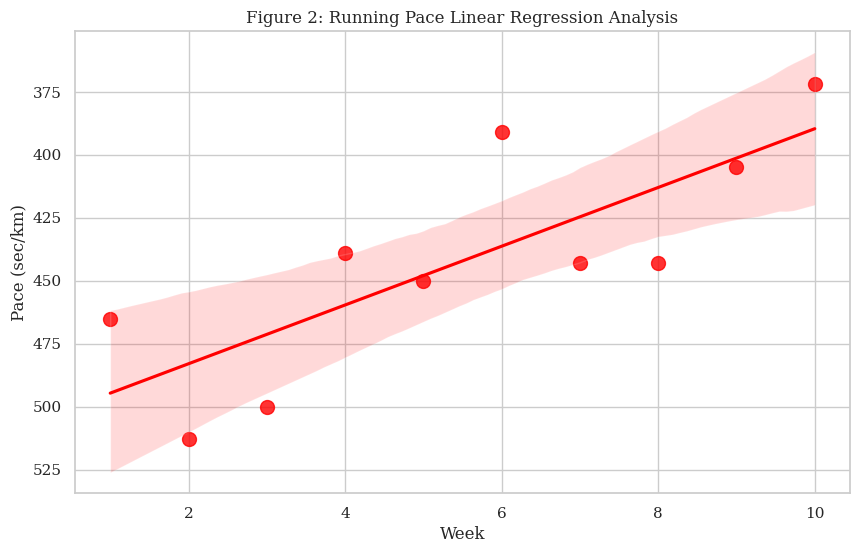

In [13]:
# --- UNNING PACE REGRESSION ---
run_df = df_final[df_final['Split'] == 'Running'].dropna(subset=['Pace_sec'])
sns.regplot(data=run_df, x='Week', y='Pace_sec', color='red', scatter_kws={'s':100})
plt.gca().invert_yaxis()
plt.title('Figure 2: Running Pace Linear Regression Analysis')
plt.ylabel('Pace (sec/km)')
plt.show()

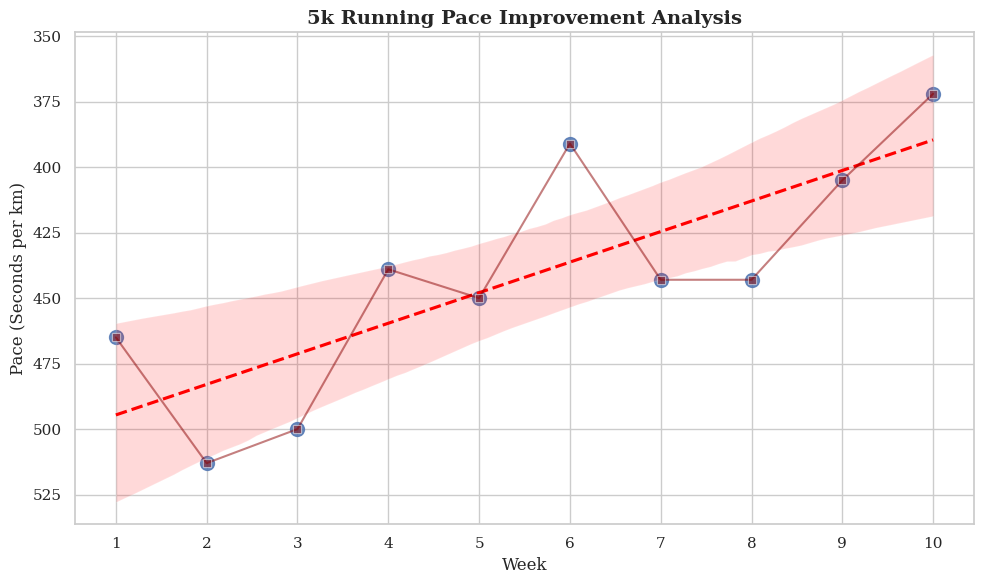

,Week,Split,Focus_Lift,Saturday_Sleep_Hours,Total_Volume_kg,Max_Rep_Weight_kg,Pace_sec
3,1,Running,5k,4.0,NaN,NaN,465.0
7,2,Running,5k,3.0,NaN,NaN,513.0
11,3,Running,5k,8.0,NaN,NaN,500.0
15,4,Running,5k,7.0,NaN,NaN,439.0
19,5,Running,5k,4.0,NaN,NaN,450.0
23,6,Running,5k,8.0,NaN,NaN,391.0
27,7,Running,5k,4.0,NaN,NaN,443.0
31,8,Running,5k,8.0,NaN,NaN,443.0
35,9,Running,5k,7.0,NaN,NaN,405.0
39,10,Running,5k,8.0,NaN,NaN,372.0


In [14]:
# --- BLOCK 5: RUNNING PACE IMPROVEMENT & REGRESSION ---
run_df = df_final[df_final['Split'] == 'Running'].dropna(subset=['Pace_sec'])

plt.figure(figsize=(10, 6))
sns.regplot(data=run_df, x='Week', y='Pace_sec', scatter_kws={'s':100}, line_kws={'color':'red', 'ls':'--'})
sns.lineplot(data=run_df, x='Week', y='Pace_sec', marker='s', color='darkred', alpha=0.5)

plt.title('5k Running Pace Improvement Analysis', fontsize=14, fontweight='bold')
plt.ylabel('Pace (Seconds per km)')
plt.gca().invert_yaxis() # Inverting because lower seconds = faster speed
plt.xticks(range(1, 11))
plt.tight_layout()
plt.show()

run_df

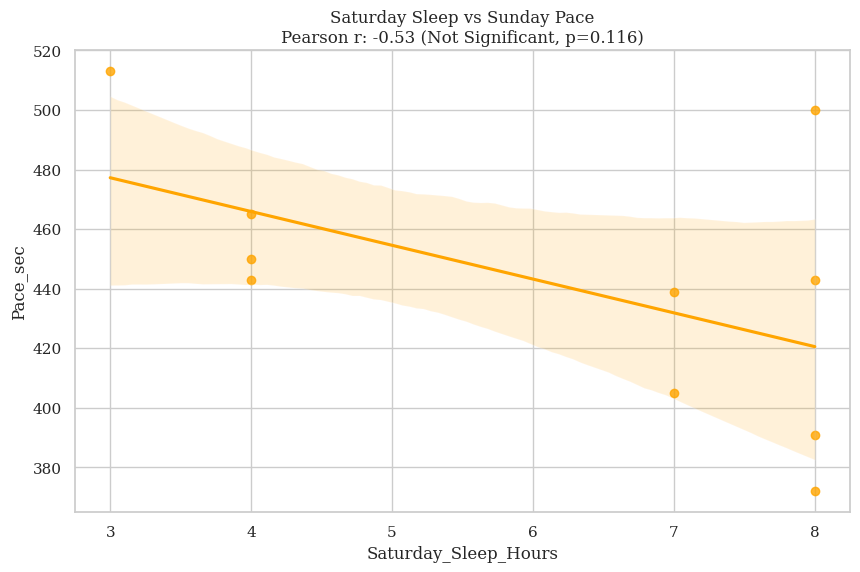

In [15]:
# --- SLEEP IMPACT VALIDATION ---
r_sleep, p_sleep = stats.pearsonr(run_df['Saturday_Sleep_Hours'], run_df['Pace_sec'])
sig_text = "Significant" if p_sleep < 0.05 else "Not Significant"

sns.regplot(x='Saturday_Sleep_Hours', y='Pace_sec', data=run_df, color='orange')
plt.title(f'Saturday Sleep vs Sunday Pace\nPearson r: {r_sleep:.2f} ({sig_text}, p={p_sleep:.3f})')
plt.show()

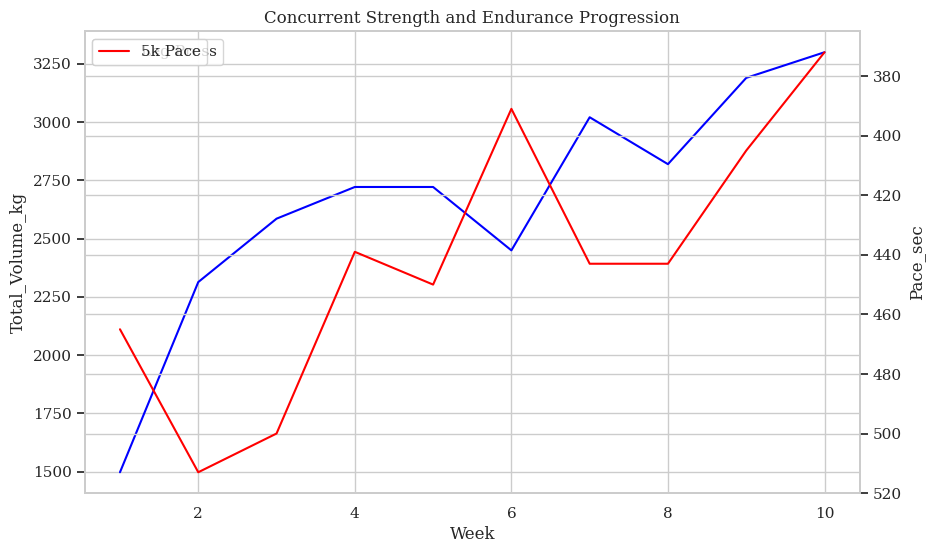

In [16]:
# --- CONCURRENT PROGRESSION ---
fig, ax1 = plt.subplots()
leg_data = df_final[df_final['Focus_Lift'] == 'Leg Press']
sns.lineplot(data=leg_data, x='Week', y='Total_Volume_kg', color='blue', ax=ax1, label='Leg Press')
ax2 = ax1.twinx()
sns.lineplot(data=run_df, x='Week', y='Pace_sec', color='red', ax=ax2, label='5k Pace')
ax2.invert_yaxis()
plt.title('Concurrent Strength and Endurance Progression')
plt.show()

In [17]:
# --- WEEKLY GROWTH & AVERAGE IMPROVEMENT (KG) ---

lifts = ['Incline Bench Machine', 'Assisted Pull-Up Machince', 'Leg Press']

print("--- WEEKLY LIFTING GROWTH & AVERAGE IMPROVEMENT (KG) ---")
for lift in lifts:
    lift_data = df_final[df_final['Focus_Lift'] == lift].groupby('Week')['Total_Volume_kg'].sum().reset_index()
    
    lift_data['Growth'] = lift_data['Total_Volume_kg'].diff()
    lift_data['Pct_Growth'] = lift_data['Total_Volume_kg'].pct_change() * 100
    
    avg_growth = lift_data['Growth'].mean()
    avg_pct_growth = lift_data['Pct_Growth'].mean()
    
    print(f"\nFocus Lift: {lift}")
    for i, row in lift_data.iterrows():
        if i == 0:
            print(f"  Week {int(row['Week'])}: Baseline Volume = {row['Total_Volume_kg']:.2f} kg")
        else:
            print(f"  Week {int(row['Week'])}: {row['Total_Volume_kg']:.2f} kg (Growth: {row['Growth']:+.2f} kg, {row['Pct_Growth']:+.2f}%)")
    
    direction = "Improvement" if avg_growth > 0 or "Pull-Up" in lift else "Change"
    print(f"  >> AVERAGE WEEKLY {direction.upper()}: {avg_growth:+.2f} kg ({avg_pct_growth:+.2f}%)")

print("\n--- WEEKLY PACING GROWTH & AVERAGE IMPROVEMENT ---")
pace_data = df_final[df_final['Split'] == 'Running'].groupby('Week')['Pace_sec'].mean().reset_index()

pace_data['Growth'] = pace_data['Pace_sec'].diff()
pace_data['Pct_Growth'] = pace_data['Pace_sec'].pct_change() * 100

avg_pace_improvement = pace_data['Growth'].mean()
avg_pace_pct_improvement = pace_data['Pct_Growth'].mean()

for i, row in pace_data.iterrows():
    if i == 0:
        print(f"  Week {int(row['Week'])}: Baseline Pace = {row['Pace_sec']:.2f} s/km")
    else:
        # Pacing improvement is represented as positive "seconds faster"
        print(f"  Week {int(row['Week'])}: {row['Pace_sec']:.2f} s/km (Improvement: {abs(row['Growth']):.2f}s, {abs(row['Pct_Growth']):.2f}% faster)")

print(f"  >> AVERAGE WEEKLY PACE IMPROVEMENT: {abs(avg_pace_improvement):.2f} seconds ({abs(avg_pace_pct_improvement):.2f}% faster)")

--- WEEKLY LIFTING GROWTH & AVERAGE IMPROVEMENT (KG) ---

Focus Lift: Incline Bench Machine
  Week 1: Baseline Volume = 1077.74 kg
  Week 2: 1167.55 kg (Growth: +89.81 kg, +8.33%)
  Week 3: 1157.57 kg (Growth: -9.98 kg, -0.85%)
  Week 4: 1077.74 kg (Growth: -79.83 kg, -6.90%)
  Week 5: 1212.45 kg (Growth: +134.72 kg, +12.50%)
  Week 6: 1122.64 kg (Growth: -89.81 kg, -7.41%)
  Week 7: 853.21 kg (Growth: -269.43 kg, -24.00%)
  Week 8: 1212.45 kg (Growth: +359.25 kg, +42.11%)
  Week 9: 1097.69 kg (Growth: -114.76 kg, -9.47%)
  Week 10: 1197.49 kg (Growth: +99.79 kg, +9.09%)
  >> AVERAGE WEEKLY IMPROVEMENT: +13.31 kg (+2.60%)

Focus Lift: Assisted Pull-Up Machince
  Week 1: Baseline Volume = 609.63 kg
  Week 2: 415.13 kg (Growth: -194.50 kg, -31.90%)
  Week 3: 428.65 kg (Growth: +13.52 kg, +3.26%)
  Week 4: 287.94 kg (Growth: -140.70 kg, -32.83%)
  Week 5: 311.94 kg (Growth: +24.00 kg, +8.33%)
  Week 6: 323.93 kg (Growth: +12.00 kg, +3.85%)
  Week 7: 287.94 kg (Growth: -35.99 kg, -11.11%)


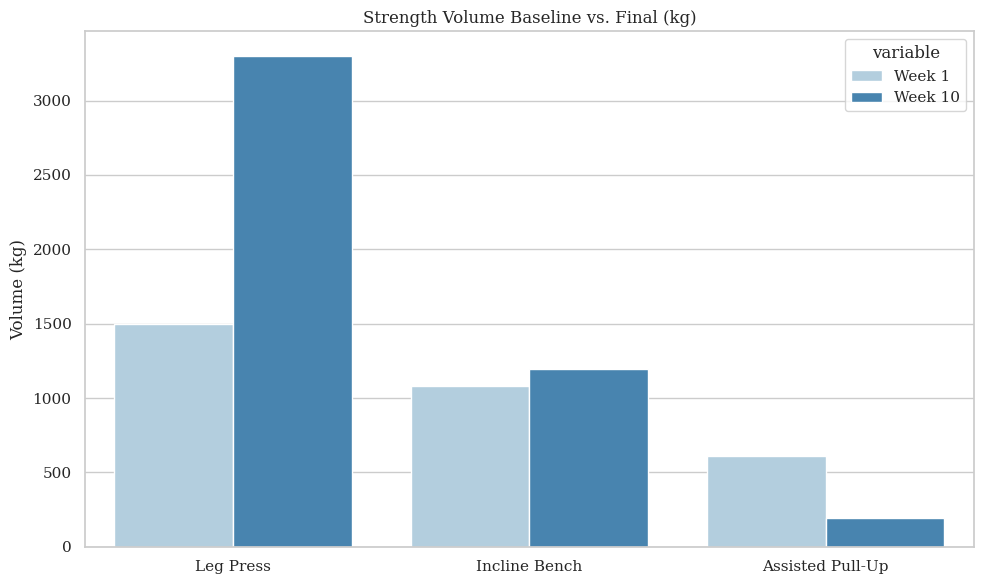

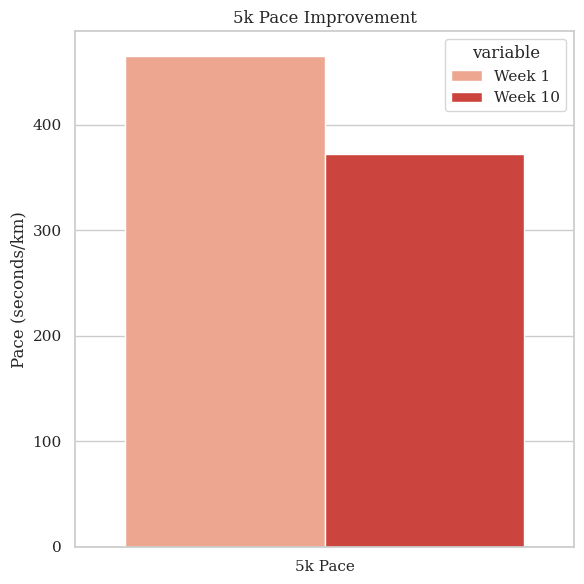

In [18]:
lift_targets = {
    'Leg Press': 'Total_Volume_kg', 
    'Incline Bench Machine': 'Total_Volume_kg', 
    'Assisted Pull-Up Machince': 'Total_Volume_kg'
}

lift_comparison = []
for name, col in lift_targets.items():
    w1 = df_final[(df_final['Week']==1) & (df_final['Focus_Lift'] == name)][col].mean()
    w10 = df_final[(df_final['Week']==10) & (df_final['Focus_Lift'] == name)][col].mean()

    display_name = "Assisted Pull-Up" if "Pull-Up" in name else name.replace(" Machine", "")
    lift_comparison.append({'Metric': display_name, 'Week 1': w1, 'Week 10': w10})

run_w1 = df_final[(df_final['Week']==1) & (df_final['Split'] == 'Running')]['Pace_sec'].iloc[0]
run_w10 = df_final[(df_final['Week']==10) & (df_final['Split'] == 'Running')]['Pace_sec'].iloc[0]
run_comparison = [{'Metric': '5k Pace', 'Week 1': run_w1, 'Week 10': run_w10}]

# --- CHART A: Strength Volume ---
plt.figure(figsize=(10, 6))
comp_lift_df = pd.DataFrame(lift_comparison).melt(id_vars='Metric')
sns.barplot(data=comp_lift_df, x='Metric', y='value', hue='variable', palette='Blues')
plt.title('Strength Volume Baseline vs. Final (kg)')
plt.ylabel('Volume (kg)')
plt.xlabel('')
plt.tight_layout()
plt.show()

# --- CHART B: Running Pace ---
plt.figure(figsize=(6, 6))
comp_run_df = pd.DataFrame(run_comparison).melt(id_vars='Metric')
sns.barplot(data=comp_run_df, x='Metric', y='value', hue='variable', palette='Reds')
plt.title('5k Pace Improvement')
plt.ylabel('Pace (seconds/km)')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [19]:
# --- STATISTICAL VALIDATION TABLE ---
def validate_model(data, x_col, y_col):
    clean = data.dropna(subset=[x_col, y_col])
    X = clean[[x_col]]
    y = clean[y_col]
    
    model = LinearRegression().fit(X, y)
    
    r2 = model.score(X, y)
    pearson_r, p_val = stats.pearsonr(clean[x_col], y)
    
    return model.coef_[0], pearson_r, p_val, r2

validation_results = []
# Validate Leg Press
slope, r, p, r2 = validate_model(df_final[df_final['Focus_Lift'] == 'Leg Press'], 'Week', 'Total_Volume_kg')
validation_results.append({'Variable': 'Leg Press', 'Slope': slope, 'Pearson r': r, 'p-value': p, 'R-Squared': r2})

# Validate Running Pace
slope, r, p, r2 = validate_model(run_df, 'Week', 'Pace_sec')
validation_results.append({'Variable': '5k Pace', 'Slope': slope, 'Pearson r': r, 'p-value': p, 'R-Squared': r2})

val_df = pd.DataFrame(validation_results).round(4)
val_df['Hypothesis'] = val_df['p-value'].apply(lambda x: 'Reject H0 (Significant)' if x < 0.05 else 'Accept H0')

print("--- FINAL STATISTICAL VALIDATION TABLE ---")
display(val_df)
val_df.to_csv('final_statistical_validation.csv')

--- FINAL STATISTICAL VALIDATION TABLE ---


,Variable,Slope,Pearson r,p-value,R-Squared,Hypothesis
0,Leg Press,146.4316,0.8627,0.0013,0.7443,Reject H0 (Significant)
1,5k Pace,-11.6667,-0.7925,0.0063,0.6281,Reject H0 (Significant)
